In [1]:
# # XAI Seminar: Experiment Runner
#
# This is the main notebook for running the illustrative experiments for our paper.
#
# **Purpose:** To visually and quantitatively demonstrate the *instability* of post-hoc explanation methods, which supports our paper's main thesis.
#
# **Steps:**
# 1.  Mount Google Drive to access our helper scripts.
# 2.  Install required libraries (`captum`, `scikit-image`, etc.).
# 3.  Import our custom helpers (`utils.py`, `models.py`, `explainers.py`).
# 4.  Define "pre-registered" images to test (to avoid cherry-picking).
# 5.  Run Experiment 1: Model Instability (ResNet vs. DenseNet).
# 6.  Run Experiment 2: Method Instability (GradCAM vs. GradCAM++ vs. IG).
# 7.  Run Experiment 3: Sanity Check (Trained vs. Random Weights).

# %%
# --- 1. Setup: Mount Drive and Install Libs ---

print("Setting up the environment...")
from google.colab import drive
drive.mount('/content/drive')

# Install our dependencies
# We install the libraries directly. This is cleaner.
print("Installing required libraries...")
!pip install captum scikit-image opencv-python-headless --quiet
!pip install grad-cam --quiet

Setting up the environment...
Mounted at /content/drive
Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 48.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pyten

In [3]:
!pip freeze | grep captum

captum==0.8.0


In [1]:
import sys

HELPER_PATH = '/content/drive/MyDrive/XAI_Seminar_Project/'

sys.path.append(HELPER_PATH)

print("Environment setup complete.")


Environment setup complete.


In [2]:
# --- 2. Imports ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import pandas as pd
# os was already imported in cell 1, but good practice to have it here too
import os

# New import for controlling the target class
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# This is a bit sloppy, but it hides all the noisy warnings from the libs
warnings.filterwarnings('ignore')

# Import our custom helper scripts
try:
    import utils
    import models
    import explainers
except ImportError as e:
    print("="*50)
    print(f"ERROR: Could not import helper files.")
    print(f"Make sure HELPER_PATH is set correctly: {HELPER_PATH}")
    print(f"Error details: {e}")
    print("="*50)

# This is useful for development
from importlib import reload
reload(utils)
reload(models)
reload(explainers)

print("All libraries and helpers imported.")

All libraries and helpers imported.


In [3]:
reload(utils)
reload(models)
reload(explainers)

<module 'explainers' from '/content/drive/MyDrive/XAI_Seminar_Project/explainers.py'>

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the path to your images folder on Google Drive
IMAGE_BASE_PATH = os.path.join(HELPER_PATH, 'images')
print(f"Looking for images in: {IMAGE_BASE_PATH}")

# We define our test images here.
# Sources are from Wikimedia Commons (CC-BY-SA license)
IMAGE_URLS = {
    # Exp 1 (Dog): English Foxhound (n02089973)
    "exp1_dog": "https://upload.wikimedia.org/wikipedia/commons/7/74/English_foxhound.jpg",

    # Exp 2 (Truck): Garbage Truck (n03417042)
    "exp2_truck": "https://upload.wikimedia.org/wikipedia/commons/b/b8/2022_Hyundai_Mighty_EX9_garbage_truck.jpg",

    # Exp 3 (Cat): Tabby Cat (n02123159)
    "exp3_cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
}
# These MUST match the filenames in your Drive folder.
IMAGE_PATHS = {
    "exp1_dog": os.path.join(IMAGE_BASE_PATH, "English_foxhound.jpg"),
    "exp2_truck": os.path.join(IMAGE_BASE_PATH, "2022_Hyundai_Mighty_EX9_garbage_truck.jpg"),
    "exp3_cat": os.path.join(IMAGE_BASE_PATH, "Cat_November_2010-1a.jpg")
}

# --- Load images from local disk ---
print("\nLoading images from Google Drive...")
pil_images = {}
for name, path in IMAGE_PATHS.items():
    if not os.path.exists(path):
        print(f"!!! FILE NOT FOUND: {path} !!!")
        pil_images[name] = None
        continue

    pil_images[name] = utils.load_image_from_path(path) # This function is in utils.py
    if pil_images[name] is None:
        print(f"Failed to load image: {name} from {path} (file might be corrupt)")
    else:
        print(f"Successfully loaded {name}")

# Preprocess them for the models
input_tensors = {name: utils.preprocess_image(img).to(DEVICE)
                 for name, img in pil_images.items() if img}

print("Images loaded and preprocessed.")

Looking for images in: /content/drive/MyDrive/XAI_Seminar_Project/images

Loading images from Google Drive...
Successfully loaded exp1_dog
Successfully loaded exp2_truck
Successfully loaded exp3_cat
Images loaded and preprocessed.


In [5]:
print("--- Starting Experiment 1: Model Instability (Revised) ---")

MODEL_NAMES_EXP1 = ['resnet50', 'densenet121']
EXPLAINER_NAME_EXP1 = 'gradcam'
IMAGE_KEY_EXP1 = 'exp1_dog'

# Check if image loaded correctly
if IMAGE_KEY_EXP1 not in input_tensors:
    print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP1} did not load. Aborting Exp 1. !!!")
else:
    input_tensor_exp1 = input_tensors[IMAGE_KEY_EXP1]

    results_exp1 = {
        "per_model_top1": {},
        "common_target": {}
    }
    model_preds = {} # Store model predictions
    class_names = utils.get_imagenet_class_names()

    # --- 1. Get model predictions first ---
    print("--- 1. Getting all model predictions ---")
    model_map = {
        "resnet50": models.get_model('resnet50', use_pretrained=True),
        "densenet121": models.get_model('densenet121', use_pretrained=True)
    }

    for name, (model, layer) in model_map.items():
        if model is None:
            print(f"Could not load {name}, skipping.")
            continue
        model = model.to(DEVICE).eval()
        output = model(input_tensor_exp1)
        pred_idx, pred_conf = utils.get_top_prediction(output)
        model_preds[name] = {"idx": pred_idx, "conf": pred_conf, "name": class_names[pred_idx]}
        print(f"   ...{name} Predicted: {model_preds[name]['name']} ({model_preds[name]['conf']*100:.2f}%)")

    # Define our fixed common target (ResNet's prediction)
    if 'resnet50' in model_preds:
        common_target_idx = model_preds['resnet50']['idx']
        print(f"   *** Setting Common Target Class to: {model_preds['resnet50']['name']} ***")
    else:
        print("!!! CRITICAL ERROR: ResNet50 failed to predict. Cannot run Exp 1B. !!!")
        common_target_idx = -1 # Set invalid


    # --- 2. Run both experiment variations ---
    for model_name in MODEL_NAMES_EXP1:
        if model_name not in model_map or model_map[model_name][0] is None:
            continue # Skip if model failed to load

        print(f"\nRunning {model_name}...")
        model, target_layer = model_map[model_name]
        model = model.to(DEVICE).eval()
        explainer_a = explainers.get_explainer(EXPLAINER_NAME_EXP1, model)

        # --- Run 1A (Per-Model Top-1) ---
        target_idx_1a = model_preds[model_name]['idx']
        print(f"   ...Explaining (1A) Per-Model target: {class_names[target_idx_1a]}")

        # Use the specific target object for pytorch-grad-cam
        targets_1a = [ClassifierOutputTarget(target_idx_1a)]
        heatmap_1a = explainer_a.explain(input_tensor_exp1, targets_1a, target_layer)
        results_exp1["per_model_top1"][model_name] = heatmap_1a

        # --- Run 1B (Common-Target) ---
        if common_target_idx != -1: # Only run if we have a valid common target
            target_idx_1b = common_target_idx
            print(f"   ...Explaining (1B) Common-Target: {class_names[target_idx_1b]}")

            # We need a new explainer object, or just set the targets
            targets_1b = [ClassifierOutputTarget(target_idx_1b)]

            # Re-using explainer 'explainer_a' is fine as long as the model is the same
            heatmap_1b = explainer_a.explain(input_tensor_exp1, targets_1b, target_layer)
            results_exp1["common_target"][model_name] = heatmap_1b

    print("\n...Experiment 1 Complete.")

--- Starting Experiment 1: Model Instability (Revised) ---
--- 1. Getting all model predictions ---
Loading pretrained ResNet-50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 284MB/s]


Loading pretrained DenseNet-121...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 208MB/s]


   ...resnet50 Predicted: English foxhound (69.44%)
   ...densenet121 Predicted: English foxhound (79.05%)
   *** Setting Common Target Class to: English foxhound ***

Running resnet50...
Initializing explainer for: gradcam
   ...Explaining (1A) Per-Model target: English foxhound
   ...Explaining (1B) Common-Target: English foxhound

Running densenet121...
Initializing explainer for: gradcam
   ...Explaining (1A) Per-Model target: English foxhound
   ...Explaining (1B) Common-Target: English foxhound

...Experiment 1 Complete.


Calculating metrics and plotting for Experiment 1...

--- Metrics for: Experiment 1A: Per-Model Top-1 (Model Disagreement) ---
  IoU @ 20.0%: 0.3127
  SSIM:        0.7792
  Pearson Corr:  0.7945
  CoM Distance:  13.56 px
Figure saved to Exp1A_Per_Model_Top1.png


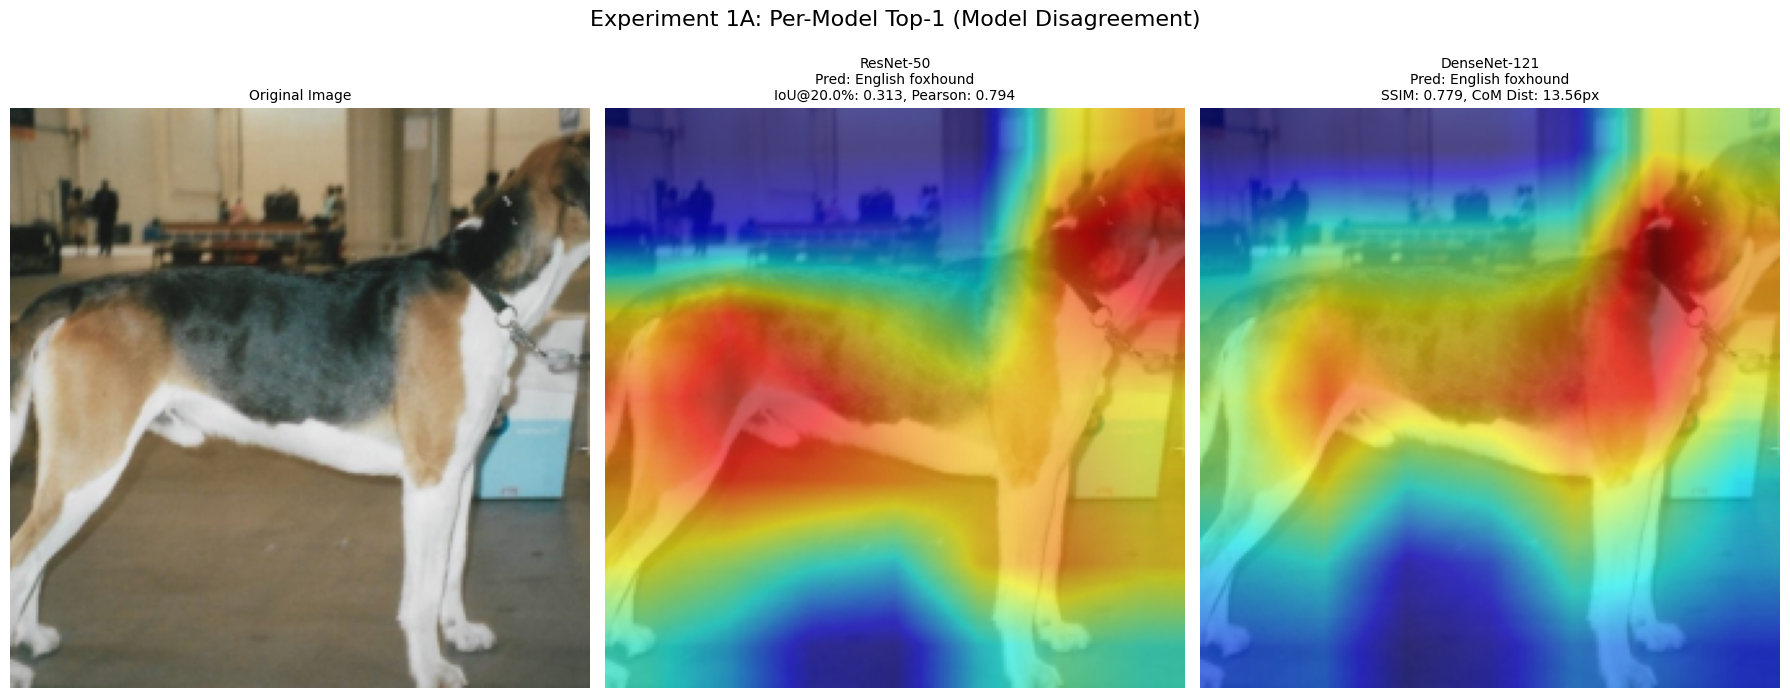


--- Metrics for: Experiment 1B: Common-Target ('English foxhound') (Architecture Effect) ---
  IoU @ 20.0%: 0.3127
  SSIM:        0.7792
  Pearson Corr:  0.7945
  CoM Distance:  13.56 px
Figure saved to Exp1B_Common_Target.png


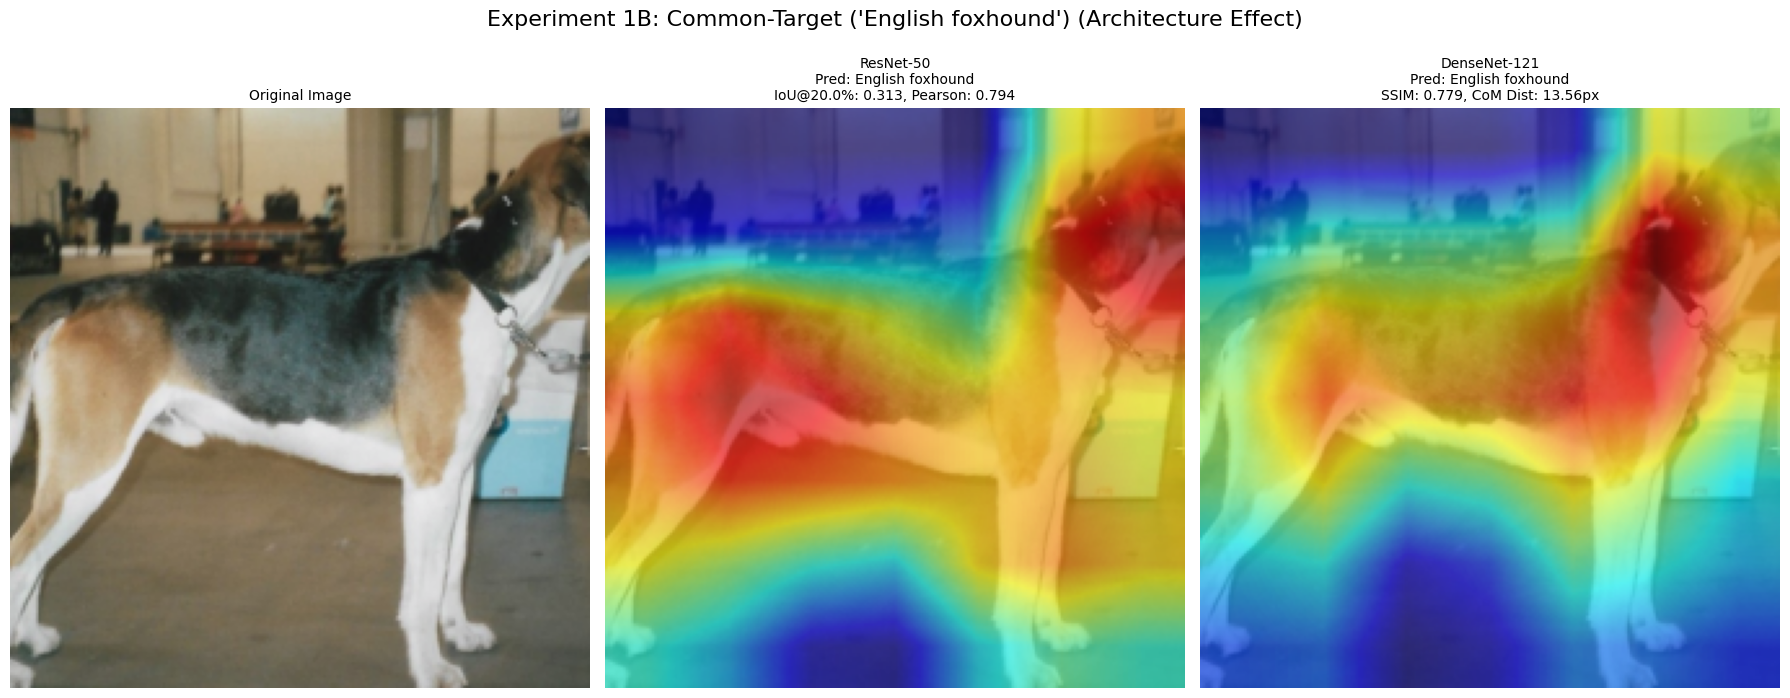

In [14]:
print("Calculating metrics and plotting for Experiment 1...")

# Check if image loaded
if IMAGE_KEY_EXP1 not in input_tensors:
     print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP1} did not load. Aborting Exp 1 plotting. !!!")
else:
    img_np = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP1])

    def analyze_and_plot(exp_results, img_np, title, filename):
        hm_resnet = exp_results.get('resnet50')
        hm_densenet = exp_results.get('densenet121')

        if hm_resnet is None or hm_densenet is None:
            print(f"Could not plot {title}, missing heatmaps.")
            return

        # Create overlays
        overlay_resnet = utils.overlay_heatmap(img_np, hm_resnet, alpha=0.6)
        overlay_densenet = utils.overlay_heatmap(img_np, hm_densenet, alpha=0.6)

        img_pil_resnet = Image.fromarray(overlay_resnet)
        img_pil_densenet = Image.fromarray(overlay_densenet)
        base_filename = filename.split('.')[0] # remove .png
        resnet_filename = f"{base_filename}_resnet_overlay.jpg"
        densenet_filename = f"{base_filename}_densenet_overlay.jpg"

        # Save
        img_pil_resnet.save(resnet_filename)
        img_pil_densenet.save(densenet_filename)

        # Calculate advanced metrics
        k = 0.2 # Use top 20% pixels for IoU
        iou_k = utils.compute_iou_at_k(hm_resnet, hm_densenet, k=k)
        ssim_val = utils.compute_ssim(hm_resnet, hm_densenet)
        pearson_corr = utils.compute_pearson_correlation(hm_resnet, hm_densenet)
        com_dist = utils.compute_center_of_mass_distance(hm_resnet, hm_densenet)

        print(f"\n--- Metrics for: {title} ---")
        print(f"  IoU @ {k*100}%: {iou_k:.4f}")
        print(f"  SSIM:        {ssim_val:.4f}")
        print(f"  Pearson Corr:  {pearson_corr:.4f}")
        print(f"  CoM Distance:  {com_dist:.2f} px")

        # Plot
        images_to_plot = [img_np, overlay_resnet, overlay_densenet]

        # Check if preds exist before trying to access them
        pred_resnet = model_preds.get('resnet50', {}).get('name', 'N/A')
        pred_densenet = model_preds.get('densenet121', {}).get('name', 'N/A')

        titles = [
            f"Original Image",
            f"ResNet-50\nPred: {pred_resnet}\nIoU@{k*100}%: {iou_k:.3f}, Pearson: {pearson_corr:.3f}",
            f"DenseNet-121\nPred: {pred_densenet}\nSSIM: {ssim_val:.3f}, CoM Dist: {com_dist:.2f}px"
        ]

        utils.plot_comparison_grid(images_to_plot, titles, (1, 3),
                                   figsize=(18, 7),
                                   main_title=title,
                                   filename=filename)

    # Plot both results
    analyze_and_plot(results_exp1["per_model_top1"], img_np,
                     "Experiment 1A: Per-Model Top-1 (Model Disagreement)",
                     "Exp1A_Per_Model_Top1.png")

    if common_target_idx != -1:
        analyze_and_plot(results_exp1["common_target"], img_np,
                         f"Experiment 1B: Common-Target ('{model_preds.get('resnet50', {}).get('name', 'N/A')}') (Architecture Effect)",
                         "Exp1B_Common_Target.png")

In [7]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
print("--- Starting Experiment 2: Method Instability ---")

MODEL_NAME_EXP2 = 'resnet50'
EXPLAINER_NAMES_EXP2 = ['gradcam', 'gradcam++', 'integratedgradients', 'eigencam']
IMAGE_KEY_EXP2 = 'exp2_truck'

if IMAGE_KEY_EXP2 not in input_tensors:
    print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP2} did not load. Aborting Exp 2. !!!")
else:
    input_tensor_exp2 = input_tensors[IMAGE_KEY_EXP2]
    results_exp2 = {}

    # Load model ONCE
    model_exp2, target_layer_exp2 = models.get_model(MODEL_NAME_EXP2, use_pretrained=True)
    if model_exp2 is None:
        print("!!! CRITICAL ERROR: Failed to load model for Exp 2. Aborting. !!!")
    else:
        model_exp2 = model_exp2.to(DEVICE).eval()

        # Get prediction ONCE
        output_exp2 = model_exp2(input_tensor_exp2)
        pred_idx_exp2, pred_conf_exp2 = utils.get_top_prediction(output_exp2)
        pred_name_exp2 = class_names[pred_idx_exp2]

        print(f"Using model: {MODEL_NAME_EXP2}")
        print(f"Targeting predicted class: {pred_name_exp2} ({pred_conf_exp2*100:.2f}%)")

        # Create the target object once
        targets_exp2 = [ClassifierOutputTarget(pred_idx_exp2)]

        # Loop over explainers
        for explainer_name in EXPLAINER_NAMES_EXP2:
            print(f"Running {explainer_name}...")
            explainer = explainers.get_explainer(explainer_name, model_exp2)

            # Pass the correct arguments
            # Note: IG explainer in explainers.py will ignore the 'targets_exp2' and 'target_layer_exp2' as needed
            if explainer_name == 'integratedgradients':
                heatmap = explainer.explain(input_tensor_exp2, pred_idx_exp2, None) # IG uses class index
            else:
                heatmap = explainer.explain(input_tensor_exp2, targets_exp2, target_layer_exp2) # CAMs use target object

            results_exp2[explainer_name] = heatmap

        print("\n...Experiment 2 Complete.")

--- Starting Experiment 2: Method Instability ---
Loading pretrained ResNet-50...
Using model: resnet50
Targeting predicted class: garbage truck (94.40%)
Running gradcam...
Initializing explainer for: gradcam
Running gradcam++...
Initializing explainer for: gradcam++
Running integratedgradients...
Initializing explainer for: integratedgradients
Running eigencam...
Initializing explainer for: eigencam

...Experiment 2 Complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Calculating metrics and plotting for Experiment 2...
Figure saved to Exp2_Method_Instability.png


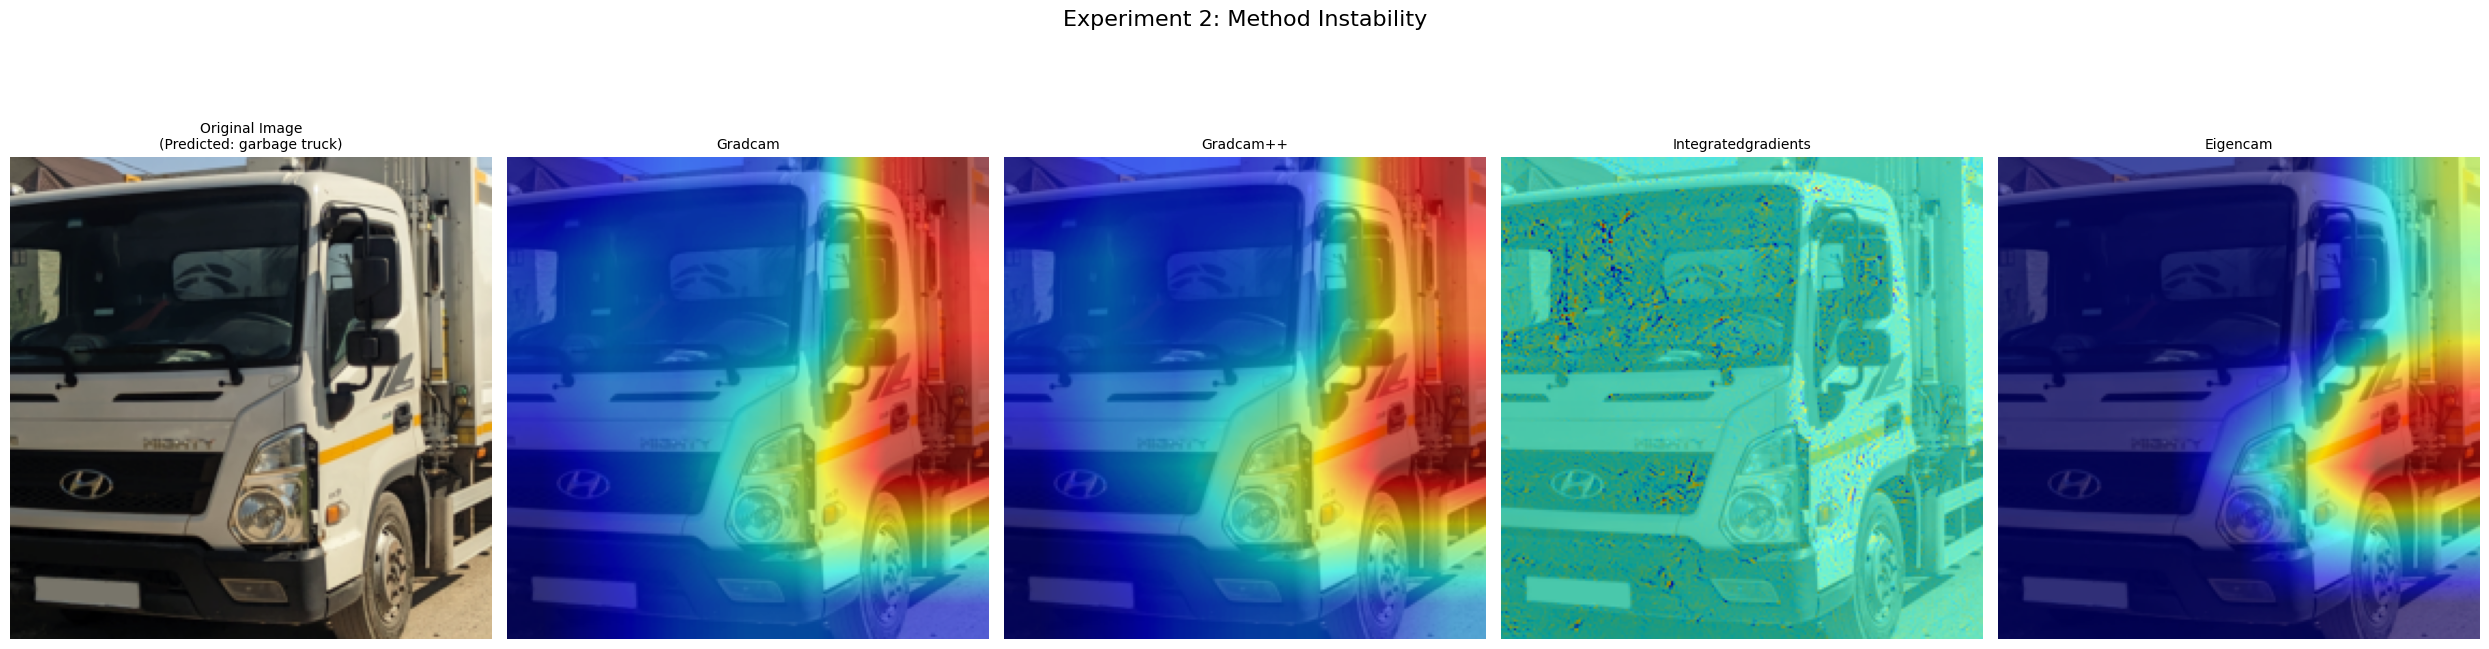


--- Pairwise Metrics for Experiment 2 ---
                                  IoU@20.0%  SSIM  Pearson
Comparison                                                
gradcam_vs_gradcam++                  0.951 0.982    0.993
gradcam_vs_integratedgradients        0.100 0.381    0.006
gradcam_vs_eigencam                   0.707 0.347    0.927
gradcam++_vs_integratedgradients      0.100 0.378    0.006
gradcam++_vs_eigencam                 0.743 0.352    0.940
integratedgradients_vs_eigencam       0.100 0.155    0.007


In [8]:
# --- 7. Plot Experiment 2 Results & Metrics ---

if IMAGE_KEY_EXP2 not in input_tensors:
     print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP2} did not load. Aborting Exp 2 plotting. !!!")
else:
    print("Calculating metrics and plotting for Experiment 2...")

    # Plot results for exp 2
    img_np_exp2 = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP2])
    images_to_plot_exp2 = [img_np_exp2]
    titles_exp2 = [f"Original Image\n(Predicted: {pred_name_exp2})"]
    overlays_exp2 = {}

    for name, hm in results_exp2.items():
        overlay = utils.overlay_heatmap(img_np_exp2, hm, alpha=0.6)
        overlays_exp2[name] = overlay
        images_to_plot_exp2.append(overlay)
        titles_exp2.append(name.capitalize())

    # Plot
    utils.plot_comparison_grid(images_to_plot_exp2, titles_exp2, (1, 5),
                               figsize=(25, 7),
                               main_title="Experiment 2: Method Instability",
                               filename="Exp2_Method_Instability.png")

    # Calculate pairwise metrics (using our new, better metrics)
    print("\n--- Pairwise Metrics for Experiment 2 ---")

    method_names = list(results_exp2.keys())
    metric_k = 0.2
    metrics_data = []

    for i in range(len(method_names)):
        for j in range(i + 1, len(method_names)):
            name1 = method_names[i]
            name2 = method_names[j]

            hm1 = results_exp2.get(name1)
            hm2 = results_exp2.get(name2)

            if hm1 is None or hm2 is None:
                print(f"Skipping metrics for {name1} vs {name2} (missing heatmap)")
                continue

            iou_k = utils.compute_iou_at_k(hm1, hm2, k=metric_k)
            ssim_val = utils.compute_ssim(hm1, hm2)
            pearson_corr = utils.compute_pearson_correlation(hm1, hm2)

            metrics_data.append({
                "Comparison": f"{name1}_vs_{name2}",
                f"IoU@{metric_k*100}%": iou_k,
                "SSIM": ssim_val,
                "Pearson": pearson_corr
            })

    if metrics_data:
        metrics_df = pd.DataFrame(metrics_data).set_index("Comparison")
        print(metrics_df.to_string(float_format="%.3f"))
    else:
        print("No metrics calculated (missing heatmaps).")

In [9]:
print("--- Starting Experiment 3: Sanity Check ---")

MODEL_NAME_EXP3 = 'resnet50'
EXPLAINER_NAME_EXP3 = 'gradcam'
IMAGE_KEY_EXP3 = 'exp3_cat'

if IMAGE_KEY_EXP3 not in input_tensors:
    print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP3} did not load. Aborting Exp 3. !!!")
else:
    input_tensor_exp3 = input_tensors[IMAGE_KEY_EXP3]
    results_exp3 = {}

    # --- 1. Run with PRETRAINED model ---
    print("Running PRETRAINED model...")
    model_trained, target_layer_trained = models.get_model(MODEL_NAME_EXP3, use_pretrained=True)
    if model_trained is None:
        print("!!! CRITICAL ERROR: Failed to load TRAINED model for Exp 3. Aborting. !!!")
    else:
        model_trained = model_trained.to(DEVICE).eval()
        output_trained = model_trained(input_tensor_exp3)
        pred_idx_trained, pred_conf_trained = utils.get_top_prediction(output_trained)
        pred_name_trained = class_names[pred_idx_trained]
        print(f"   ...Predicted: {pred_name_trained} ({pred_conf_trained*100:.2f}%)")

        explainer_trained = explainers.get_explainer(EXPLAINER_NAME_EXP3, model_trained)
        targets_trained = [ClassifierOutputTarget(pred_idx_trained)]
        results_exp3['trained'] = explainer_trained.explain(input_tensor_exp3, targets_trained, target_layer_trained)

    # --- 2. Run with RANDOM model ---
    print("\nRunning RANDOM weights model...")
    model_random, target_layer_random = models.get_model_with_random_weights(MODEL_NAME_EXP3)
    if model_random is None:
        print("!!! CRITICAL ERROR: Failed to load RANDOM model for Exp 3. Aborting. !!!")
    else:
        model_random = model_random.to(DEVICE).eval()
        output_random = model_random(input_tensor_exp3)
        pred_idx_random, pred_conf_random = utils.get_top_prediction(output_random)
        pred_name_random = class_names[pred_idx_random]
        print(f"   ...Predicted: {pred_name_random} ({pred_conf_random*100:.2f}%)") # Garbage

        explainer_random = explainers.get_explainer(EXPLAINER_NAME_EXP3, model_random)
        targets_random = [ClassifierOutputTarget(pred_idx_random)]
        results_exp3['random'] = explainer_random.explain(input_tensor_exp3, targets_random, target_layer_random)

    print("\n...Experiment 3 Complete.")

--- Starting Experiment 3: Sanity Check ---
Running PRETRAINED model...
Loading pretrained ResNet-50...
   ...Predicted: tiger cat (45.97%)
Initializing explainer for: gradcam

Running RANDOM weights model...
Loading resnet50 with RANDOM weights...
Loading pretrained ResNet-50...
...Model weights have been re-initialized.
   ...Predicted: Rottweiler (99.87%)
Initializing explainer for: gradcam

...Experiment 3 Complete.


Plotting for Experiment 3...
Figure saved to Exp3_Sanity_Check.png


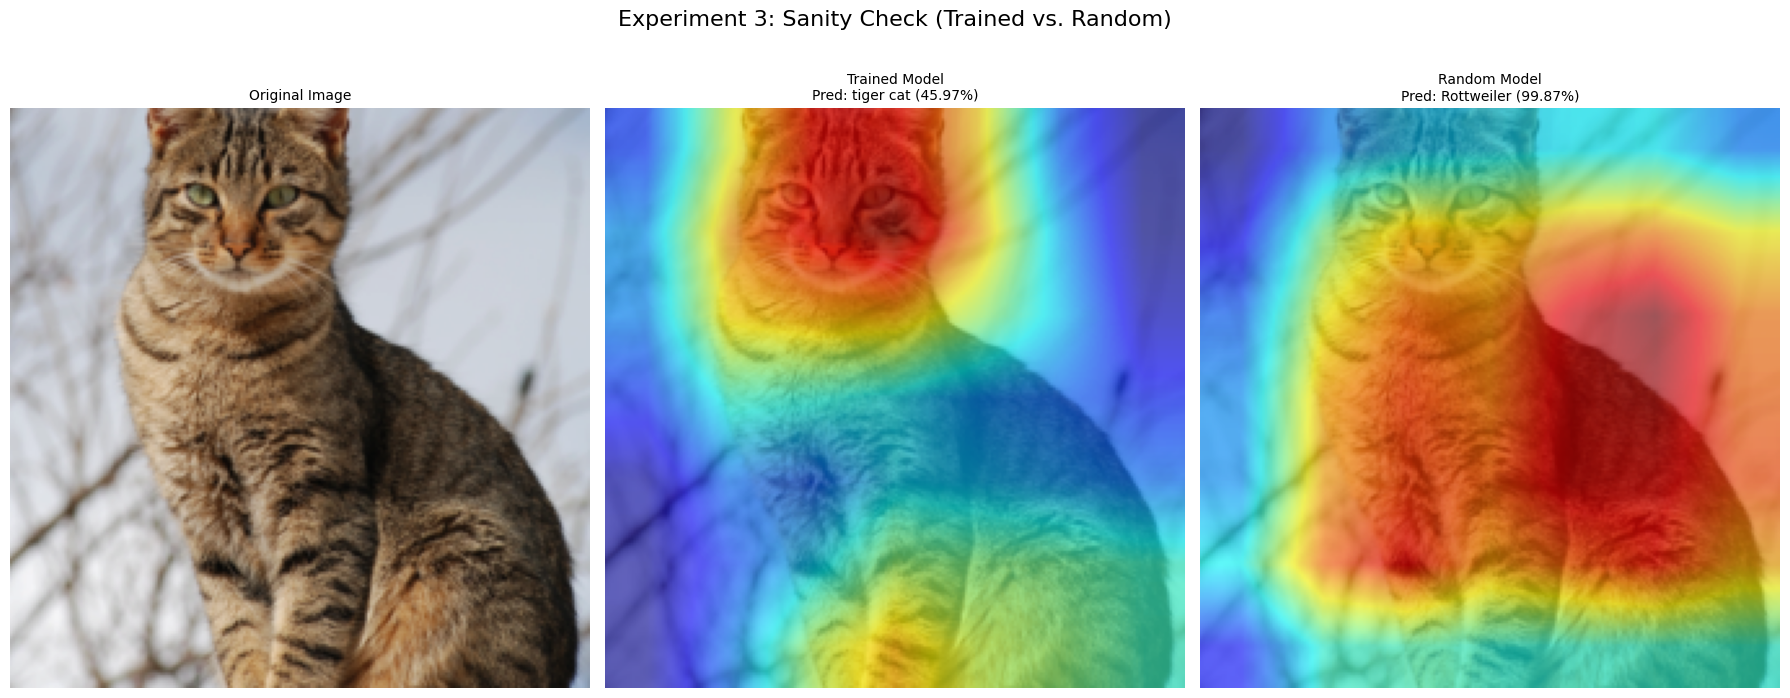

In [10]:
# --- 9. Plot Experiment 3 Results ---

if IMAGE_KEY_EXP3 not in input_tensors:
     print(f"!!! CRITICAL ERROR: Image {IMAGE_KEY_EXP3} did not load. Aborting Exp 3 plotting. !!!")
else:
    print("Plotting for Experiment 3...")
    img_np_exp3 = utils.de_normalize_image(input_tensors[IMAGE_KEY_EXP3])

    hm_trained = results_exp3.get('trained')
    hm_random = results_exp3.get('random')

    if hm_trained is not None and hm_random is not None:
        overlay_trained = utils.overlay_heatmap(img_np_exp3, hm_trained, alpha=0.6)
        overlay_random = utils.overlay_heatmap(img_np_exp3, hm_random, alpha=0.6)

        # Plot
        images_to_plot_exp3 = [img_np_exp3, overlay_trained, overlay_random]
        titles_exp3 = [
            f"Original Image",
            f"Trained Model\nPred: {pred_name_trained} ({pred_conf_trained*100:.2f}%)",
            f"Random Model\nPred: {pred_name_random} ({pred_conf_random*100:.2f}%)"
        ]

        utils.plot_comparison_grid(images_to_plot_exp3, titles_exp3, (1, 3),
                                   figsize=(18, 7),
                                   main_title="Experiment 3: Sanity Check (Trained vs. Random)",
                                   filename="Exp3_Sanity_Check.png")
    else:
        print("Could not plot Exp3, missing one or more heatmaps.")

In [11]:
# %%
# --- 10. Future Experiment Ideas ---

# TODO: Try to do the 'label randomization' sanity check
# This means using the TRAINED model but targeting a *wrong* class
# and see if the heatmap changes.

# print("\n--- Starting Sanity Check 2: Label Randomization ---")
# model, layer = models.get_model('resnet50', use_pretrained=True)
# model = model.to(DEVICE).eval()

# input_tensor = input_tensors['sanity_check']
# output = model(input_tensor)
# pred_idx_correct, _ = utils.get_top_prediction(output)

# # Pick a wrong class (e.g., the 10th prediction)
# top_preds = utils.get_top_n_predictions(output, n=10)
# pred_idx_wrong = utils.get_imagenet_class_names().index(top_preds[9][0])

# print(f"Targeting correct class: {class_names[pred_idx_correct]}")
# print(f"Targeting wrong class: {class_names[pred_idx_wrong]}")

# explainer = explainers.get_explainer('gradcam', model)

# hm_correct = explainer.explain(input_tensor, pred_idx_correct, layer)
# hm_wrong = explainer.explain(input_tensor, pred_idx_wrong, layer)

# # Plot...
# # img_np = utils.de_normalize_image(input_tensor)
# # overlay_correct = utils.overlay_heatmap(img_np, hm_correct)
# # overlay_wrong = utils.overlay_heatmap(img_np, hm_wrong)
# # ...

print("\n--- END OF NOTEBOOK ---")


--- END OF NOTEBOOK ---
